In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import nltk

# Constants
DF_LOC = '../dataset/twitter-spam/train.csv'

# 1. Base Model

In [2]:
raw_df = pd.read_csv(DF_LOC).drop('following', axis=1).drop('followers', axis=1).drop('actions', axis=1).drop('is_retweet', axis=1).drop('location', axis=1).drop('Unnamed: 7', axis=1)
raw_df.iloc[7552]

Tweet    #Virgos are usually very helpful around the ho...
Type                                          South Dakota
Name: 7552, dtype: object

In [3]:
# Preprocess type
raw_df['Type'] = raw_df['Type'].map({'Quality': 0, 'Spam': 1})
raw_df.head()

,Tweet,Type
0,Good Morning Love @LeeBrown_V,0.0
1,'@realDonaldTrump @USNavy RIP TO HEROES',1.0
2,Haven't been following the news but I understa...,0.0
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,0.0


In [4]:
raw_df = raw_df.drop(raw_df['Type'].loc[raw_df['Type'].isnull()].index.values)
# raw_df.isnull()

In [5]:
raw_df['Type'].loc[raw_df['Type'].isnull()]

Series([], Name: Type, dtype: float64)

In [8]:
for i in raw_df.iterrows():
    print(i)

(0, Tweet    Good Morning Love  @LeeBrown_V
Type                                0.0
Name: 0, dtype: object)
(1, Tweet    '@realDonaldTrump @USNavy RIP TO HEROES'
Type                                          1.0
Name: 1, dtype: object)
(2, Tweet    Haven't been following the news but I understa...
Type                                                   0.0
Name: 2, dtype: object)
(3, Tweet    pic.twitter.com/dy9q4ftLhZ What to do with pap...
Type                                                   0.0
Name: 3, dtype: object)
(4, Tweet    #DidYouKnow ► Mahatma Gandhi made a brief visi...
Type                                                   0.0
Name: 4, dtype: object)
(5, Tweet    #amms Samantha Bee Tries to ATTACK Trump, Inst...
Type                                                   1.0
Name: 5, dtype: object)
(6, Tweet    please don't talk about me like that i'm only ...
Type                                                   0.0
Name: 6, dtype: object)
(7, Tweet    Politicshttps://twitt

In [6]:
# More data cleanup
raw_df['Tweet'].replace('(\@[A-Za-z0-9_]+)', ' <username> ', regex=True, inplace=True) # Username obfuscation
raw_df['Tweet'].replace(r'([http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*))', ' <link> ', regex=True, inplace=True) # Link obfuscation
raw_df['Tweet'].replace('(\#[A-Za-z]+)', ' <hashtag> ', regex=True, inplace=True) # Hashtag obfuscation
raw_df['Tweet'].replace('[^\w <>]*', '', regex=True, inplace=True)

In [7]:
raw_df.head()

,Tweet,Type
0,Good Morning Love <username>,0.0
1,<username> <username> RIP TO HEROES,1.0
2,Havent been following the news but I understan...,0.0
3,<link> What to do with paper scissors and gl...,0.0
4,<hashtag> Mahatma Gandhi made a brief visit...,0.0


In [6]:
len(raw_df)

14897

In [8]:
raw_df.to_csv('../dataset/twitter-spam/train-cleaned.csv')

In [9]:
sentences = raw_df['Tweet']

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)

In [10]:
sentences

0                          Good Morning Love   <username> 
1                   <username>   <username>  RIP TO HEROES
2        Havent been following the news but I understan...
3         <link>  What to do with paper scissors and gl...
4         <hashtag>   Mahatma Gandhi made a brief visit...
                               ...                        
14894         <hashtag>  I told my hair stylist to go nuts
14895    They dont have to like you and you dont have t...
14896     <hashtag>  Graham Nash Live at Parker Playhou...
14897     <username>  is in the business of oneupping m...
14898      Chasing Success  by  Space Cadetz  Listen up...
Name: Tweet, Length: 14897, dtype: object

In [11]:
# Saving via pickle
import pickle
with open('../dataset/basic-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
INPUT_LENGTH = 75

In [13]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=INPUT_LENGTH)

print(padded[0])
print(padded.shape)

[ 75 202  66   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(14897, 75)


In [14]:
# len(tokenizer.word_index)
len(tokenizer.word_index)

22156

In [15]:
EMBEDDING_DIMS = int(len(tokenizer.word_index)**0.25)
EMBEDDING_DIMS

12

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIMS, input_length=INPUT_LENGTH),
    tf.keras.layers.LSTM(256),
    # tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 75, 12)            265884    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               275456    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 541,597
Trainable params: 541,597
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(padded, raw_df['Type'].values, epochs=200, batch_size=16, verbose=2)

Epoch 1/200
932/932 - 15s - loss: 0.6932 - binary_accuracy: 0.4978
Epoch 2/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4980
Epoch 3/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4957
Epoch 4/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4980
Epoch 5/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4965
Epoch 6/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4975
Epoch 7/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4950
Epoch 8/200
932/932 - 15s - loss: 0.6932 - binary_accuracy: 0.4941
Epoch 9/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.5004
Epoch 10/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4989
Epoch 11/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4989
Epoch 12/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4988
Epoch 13/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4997
Epoch 14/200
932/932 - 14s - loss: 0.6932 - binary_accuracy: 0.4986
Epoch 15/200
932/932 - 14s - loss: 0.6932 - binary_accura

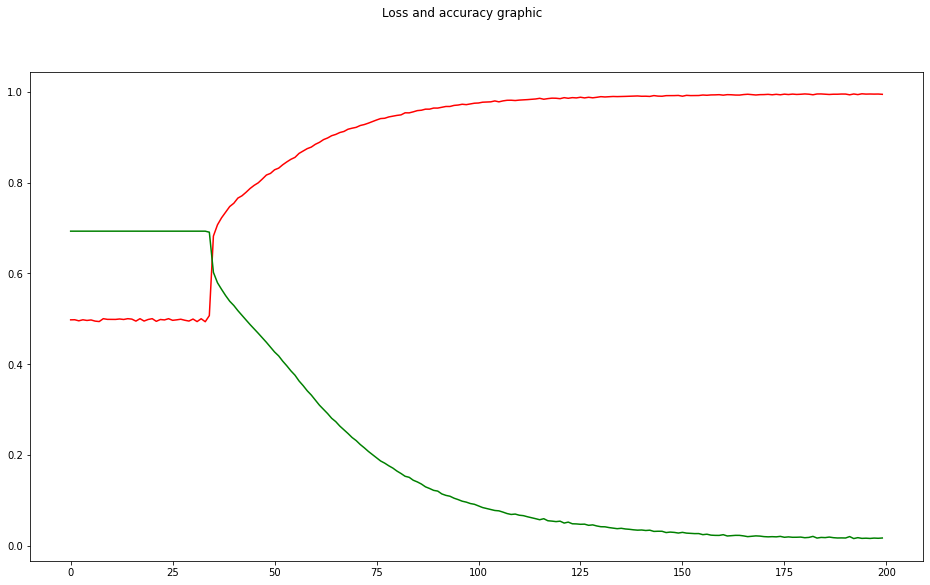

In [33]:
plt.rcParams['figure.figsize'] = (16,9)

# fig, axs = plt.subplots(1, 2)
plt.suptitle('Loss and accuracy graphic')
plt.plot(range(len(history.history['loss'])), history.history['binary_accuracy'], 'r-', history.history['loss'], 'g-')
# axs[1].plot(range(len(history.history['loss'])), history.history['loss'], 'tab:brown', history.history['val_loss'], 'y')
plt.show()

In [34]:
model.save('../model/twitter-spam')

2021-11-05 18:59:31.641845: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/twitter-spam/assets


INFO:tensorflow:Assets written to: ../model/twitter-spam/assets


In [35]:
# Testing
squid_df = pd.read_json('../dataset/squid-tweets/squid_tweets.json')
squid_df = squid_df.rename(columns={0: "tweets"})
squid_df.head()

,tweets
0,"#BTS, #TXT, And ""#SquidGame"" Nominated For 202..."
1,tim pool watched squid game and somehow missed...
2,Squid Game is short for Squidward’s Gambit
3,Having tons of money doesn’t mean anything if ...
4,Squid game\n\nBAZINGA MV BUKAS NA\n@SB19Offici...


In [36]:
input_pred = tokenizer.texts_to_sequences(squid_df['tweets'])
# print(input_pred, end='\n===\n')
input_pad = tf.keras.preprocessing.sequence.pad_sequences(input_pred, padding='post', maxlen=71)
# print(input_pad, end='\n===\n')
is_spam = model.predict(input_pad)

squid_df['is_spam'] = [True if i >= 0.5 else False for i in is_spam]

# for i in squid_df['tweets']:
#     input_pred = tokenizer.texts_to_sequences(i)
#     print(input_pred, end='\n===\n')
#     input_pad = tf.keras.preprocessing.sequence.pad_sequences([input_pred], padding='post', maxlen=71)
#     print(input_pad, end='\n===\n')
#     model.predict(input_pad)

In [37]:
squid_df.head()

,tweets,is_spam
0,"#BTS, #TXT, And ""#SquidGame"" Nominated For 202...",False
1,tim pool watched squid game and somehow missed...,True
2,Squid Game is short for Squidward’s Gambit,True
3,Having tons of money doesn’t mean anything if ...,False
4,Squid game\n\nBAZINGA MV BUKAS NA\n@SB19Offici...,False


In [130]:
!pip install openpyxl
squid_df.to_excel('../dataset/squid-tweets/squid-dataset.xlsx')

     |████████████████████████████████| 242 kB 527 kB/s 


In [ ]:
squid_df['spam'] = model.predict()